# Preprocess and Save the data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
import joblib

class Preprocessor:
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = AutoModel.from_pretrained('bert-base-uncased').to(self.device)
        self.tfidf = TfidfVectorizer(max_features=100)

    def extract_bert_embeddings(self, texts, batch_size=32):
        # Extract BERT embeddings in batches
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size].tolist()
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(self.device)
            with torch.no_grad():
                outputs = self.bert_model(**inputs)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())
        return np.vstack(embeddings)

    def preprocess(self, df):
        # Compute BERT embeddings
        prompt_embeddings = self.extract_bert_embeddings(df['prompt'])
        response_a_embeddings = self.extract_bert_embeddings(df['response_a'])
        response_b_embeddings = self.extract_bert_embeddings(df['response_b'])

        # Compute TF-IDF features
        tfidf_features = self.tfidf.fit_transform(df['prompt']).toarray()

        # Combine features
        features = np.hstack([
            prompt_embeddings,
            response_a_embeddings,
            response_b_embeddings,
            tfidf_features
        ])

        return features

# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Initialize preprocessor
preprocessor = Preprocessor()

# Preprocess and save train data
X_train = preprocessor.preprocess(train_df)
np.save('X_train.npy', X_train)

# Preprocess and save test data
X_test = preprocessor.preprocess(test_df)
np.save('X_test.npy', X_test)

# Save targets
y_train = np.zeros(len(train_df))
y_train[train_df['winner_model_a'] == 1] = 0
y_train[train_df['winner_model_b'] == 1] = 1
y_train[train_df['winner_tie'] == 1] = 2
np.save('y_train.npy', y_train)

print("Preprocessing complete. Features and targets saved.")


# Training the model

In [2]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Load preprocessed features and targets
X_train = np.load('data1/X_train.npy')
y_train = np.load('data1/y_train.npy')

# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Train LightGBM model
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}
train_data = lgb.Dataset(X_train_split, label=y_train_split)
val_data = lgb.Dataset(X_val_split, label=y_val_split)

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Save the trained model
model.save_model('trained_model.txt')
print("Model trained and saved.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.778135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 612945
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 2404
[LightGBM] [Info] Start training from score -1.052057
[LightGBM] [Info] Start training from score -1.067750
[LightGBM] [Info] Start training from score -1.180908
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	training's multi_logloss: 0.856118	valid_1's multi_logloss: 1.03827
Model trained and saved.


# Metrics and Accuracy

Accuracy on Validation Data: 46.69%
RMSE on Validation Data: 0.4561
Log Loss on Validation Data: 1.0383

Classification Report:
              precision    recall  f1-score   support

     Model A       0.47      0.53      0.50      2794
     Model B       0.47      0.52      0.50      2750
         Tie       0.45      0.33      0.38      2456

    accuracy                           0.47      8000
   macro avg       0.46      0.46      0.46      8000
weighted avg       0.47      0.47      0.46      8000


Confusion Matrix:
[[1487  810  497]
 [ 831 1441  478]
 [ 835  814  807]]


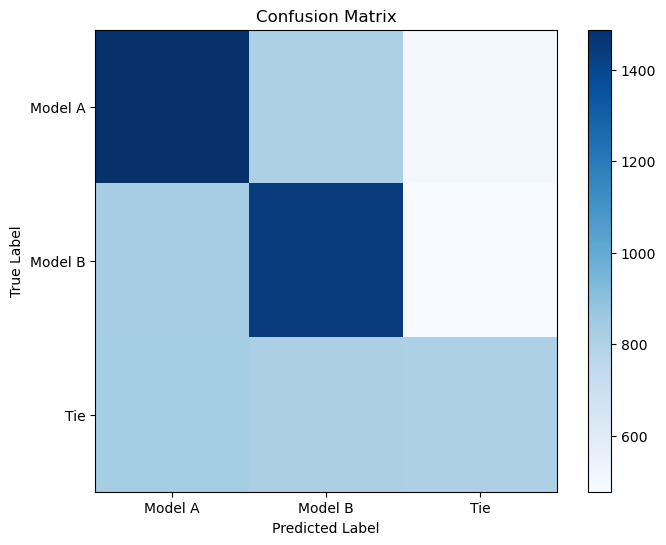

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt

# Load data
X_train = np.load('data1/X_train.npy')  # Features
y_train = np.load('data1/y_train.npy')  # True labels

# Ensure y_train is of integer type
y_train = y_train.astype(int)

# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Load the trained model
model = lgb.Booster(model_file='trained_model.txt')

# Predict probabilities on the validation set
val_probs = model.predict(X_val_split)

# Convert probabilities to predicted classes
val_preds = np.argmax(val_probs, axis=1)

# Accuracy
accuracy = accuracy_score(y_val_split, val_preds)
print(f"Accuracy on Validation Data: {accuracy * 100:.2f}%")

# RMSE
# Prepare one-hot-encoded true labels for RMSE calculation
y_val_one_hot = np.zeros_like(val_probs)
y_val_one_hot[np.arange(len(y_val_split)), y_val_split] = 1  # One-hot encoding
rmse = np.sqrt(mean_squared_error(y_val_one_hot, val_probs))
print(f"RMSE on Validation Data: {rmse:.4f}")

# Log Loss
logloss = log_loss(y_val_split, val_probs)
print(f"Log Loss on Validation Data: {logloss:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val_split, val_preds, target_names=["Model A", "Model B", "Tie"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_split, val_preds)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1, 2], labels=["Model A", "Model B", "Tie"])
plt.yticks(ticks=[0, 1, 2], labels=["Model A", "Model B", "Tie"])
plt.show()